In [1]:
import pandas as pd
cnvs = pd.read_csv('../analysis/merged_cnvs.txt', sep="\t", header=0, index_col=0, low_memory=False)
cnvs_genes = pd.read_csv('../analysis/merged_cnvs_genes.txt', sep="\t", header=0, index_col=0)

In [2]:
metasamples = pd.read_excel('../Metadata4.xlsx')

# Keep only samples that are tumor-normal pair and labeled as included
df = metasamples.loc[(metasamples['INCLUDED'] == "Y")
                     & (metasamples['TUMOR_ONLY'] == "No")
                     & (metasamples['SAMPLE_TYPE'] != "gDNA"), 
                     ['PATIENT_ID', 'SAMPLE_ID']]
metasamples.index = metasamples['SAMPLE_ID']
meta_filtered = metasamples.reindex(df['SAMPLE_ID'].tolist())
SAMPLES = [x.strip() for x in df['SAMPLE_ID'] + '-' + df['PATIENT_ID']]
meta_filtered.index = SAMPLES

# Load CNVs and sort them by chromosome
cnvs = cnvs.loc[:, cnvs.columns[0:3].to_list() + SAMPLES]
cnvs = cnvs.drop(['chrX', 'chrY'])
cnvs.index = [x.replace('chr','') for x in cnvs.index]
cnvs.index = cnvs.index.astype(int)
cnvs = cnvs.sort_index()

In [12]:
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
import seaborn as sns
from matplotlib.patches import Patch

figsize = (16,16) 
color_map = ["red", "green", "blue", "orange", "cyan", "yellow", "orchid", 
             "saddlebrown", "darkcyan", "gray", "darkred", "darkgreen", "darkblue", 
             "antiquewhite", "bisque", "black", "slategray", "gold", "floralwhite",
             "aliceblue", "plum", "cadetblue", "coral", "olive", "khaki", "lightsalmon"]

def plot_heatmap(data, meta, title, filename, col_cluster, row_cluster):
    
    meta = meta.reindex(data.index)

    var1_colors = [color_map[0] if x == 'E' else color_map[1] for x in meta['VAR2']]
    var2_colors = [color_map[2] if x == 'BEFORE' else color_map[3] if x == 'AFTER' else (1,1,1) for x in meta['VAR1']]
    var3 = meta['VAR3'].copy()
    var3.loc[var3 == 'CR'] = color_map[4]
    var3.loc[var3 == 'PD'] = color_map[5]
    var3.loc[var3 == 'PR'] = color_map[6]
    var3.loc[var3 == 'long SD'] = color_map[7]
    var3.loc[var3 == 'short SD'] = color_map[8]
    var3_colors = var3.to_list()
    var7_colors = [color_map[9] if x == 'doblete' else color_map[10] for x in meta['VAR7']]

    ax = sns.clustermap(data,
                        mask=data.isnull(),
                        z_score=None,
                        cmap=matplotlib.cm.bwr,
                        rasterized=True,
                        metric='euclidean',
                        method='average',
                        yticklabels=1,
                        row_colors=[var1_colors, var2_colors, var3_colors, var7_colors],
                        col_cluster=col_cluster,
                        row_cluster=row_cluster,
                        vmax=np.nanmin(data),
                        vmin=np.nanmax(data))
    
    handles = [Patch(color=color_map[0], label='E'),
               Patch(color=color_map[1], label='F'),
               Patch(color=color_map[2], label='BEFORE'),
               Patch(color=color_map[3], label='AFTER'),
               Patch(color=color_map[4], label='CR'),
               Patch(color=color_map[5], label='PD'),
               Patch(color=color_map[6], label='PR'),
               Patch(color=color_map[7], label='long SD'),
               Patch(color=color_map[8], label='short SD'),
               Patch(color=color_map[9], label='doblete'),
               Patch(color=color_map[10], label='triplete')]
    ax.ax_heatmap.set_title(title, fontsize=12)
    ax.ax_heatmap.set_xlabel("Positions",fontsize=10)
    ax.ax_heatmap.set_ylabel("Samples", fontsize=10)
    ax.ax_heatmap.tick_params(labelsize=7)
    ax.cax.set_visible(True)
    ax.ax_row_dendrogram.legend(handles=handles, loc="upper left")
    ax.savefig(filename)
    
def plot_pca(x, y, colors, labels, title, filename):
    unique_colors = set(colors)
    color_values = [color_map[i] for i in unique_colors]
    colors = [color_map[i] for i in colors]

    fig, ax = plt.subplots(figsize=(12,12))
    sc = ax.scatter(x, y, 
                    c=colors, 
                    edgecolor="none", 
                    cmap=None, 
                    s=20)

    ax.set_xlabel('PCA1')
    ax.set_ylabel('PCA2')
    ax.set_title(title, size=8)
    ax.legend([plt.Line2D((0, 1), (0, 0), color=x) for x in color_values],
              labels, loc="upper right", markerscale=1.0,
              ncol=1, scatterpoints=1, fontsize=8)
    fig.savefig(filename)

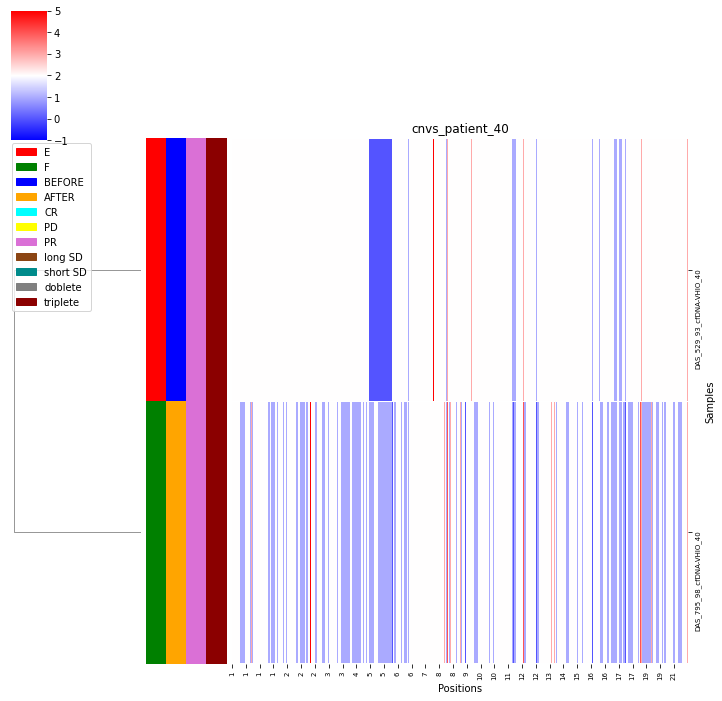

In [4]:
patient_40 = meta_filtered[(meta_filtered['PATIENT_ID'] == 'VHIO_40') 
                           & (meta_filtered['SAMPLE_TYPE'] == "cfDNA")].index
cnvs_40 = cnvs.loc[:, cnvs.columns[0:2].to_list() + patient_40.tolist()]
data = cnvs_40.iloc[:,2:].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data = data.dropna(how='all', axis=0)
data = data.dropna(how='all', axis=1)
data[data > 5.0] = 5
data = data.fillna(2)
name = 'cnvs_patient_40'
plot_heatmap(data, meta_filtered, name, name + "_scaled.pdf", False, True)

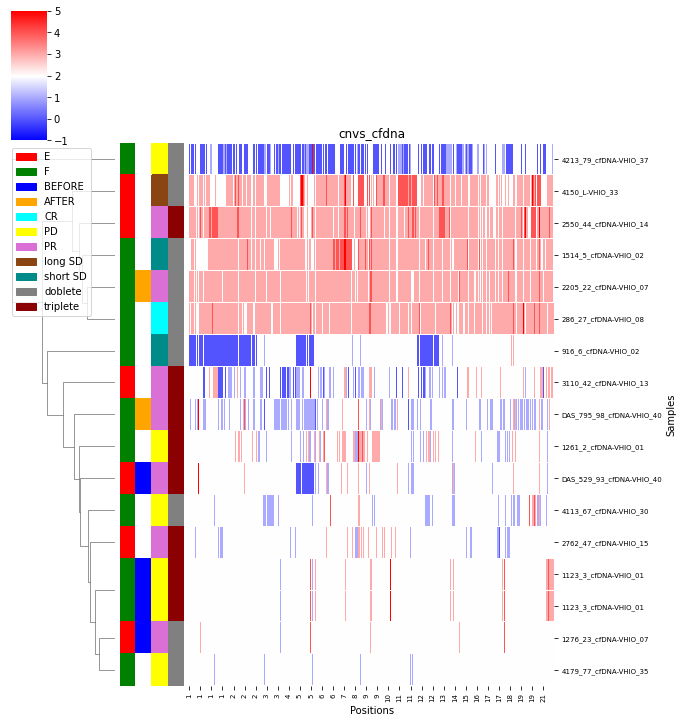

In [5]:
cfdna_samples = meta_filtered[(meta_filtered['SAMPLE_TYPE'] == "cfDNA")].index
cnvs_cfdna = cnvs.loc[:, cnvs.columns[0:2].to_list() + cfdna_samples.tolist()]
data = cnvs_cfdna.iloc[:,2:].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data = data.dropna(how='all', axis=0)
data = data.dropna(how='all', axis=1)
data[data > 5.0] = 5
data = data.fillna(2)
name = 'cnvs_cfdna'
plot_heatmap(data, meta_filtered, name, name + "_scaled.pdf", False, True)

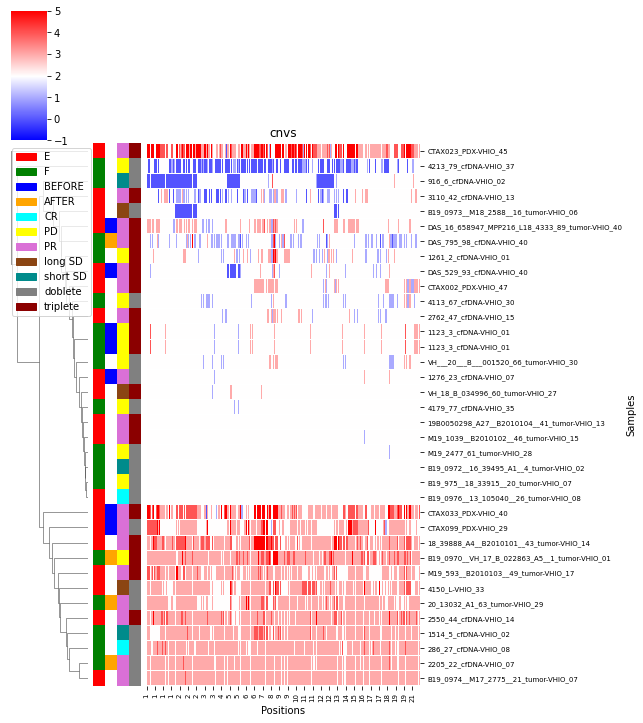

In [6]:
data = cnvs.iloc[:,2:].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data = data.dropna(how='all', axis=0)
data = data.dropna(how='all', axis=1)
data[data > 5.0] = 5
data = data.fillna(2)
name = 'cnvs'
plot_heatmap(data, meta_filtered, name, name + "_scaled.pdf", False, True)

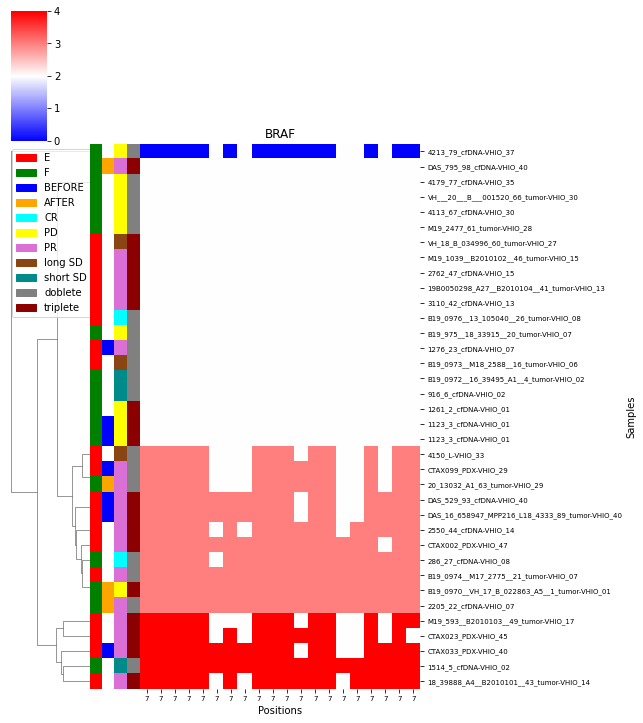

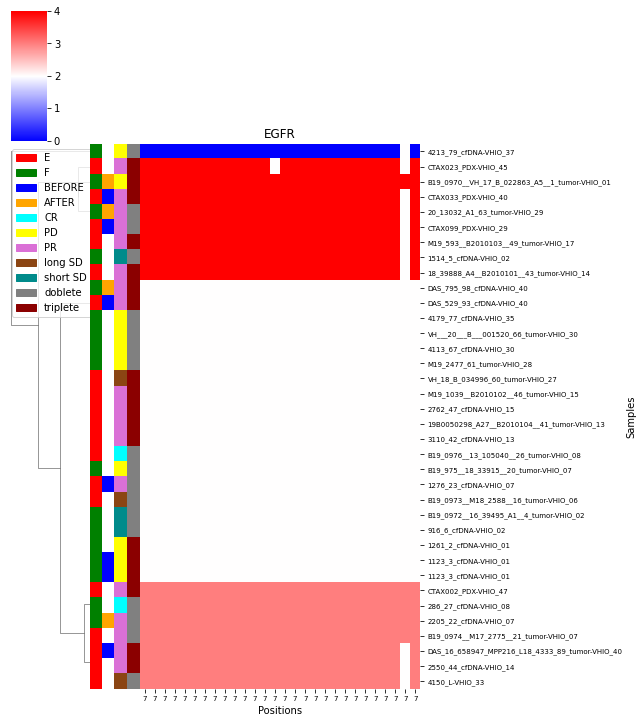

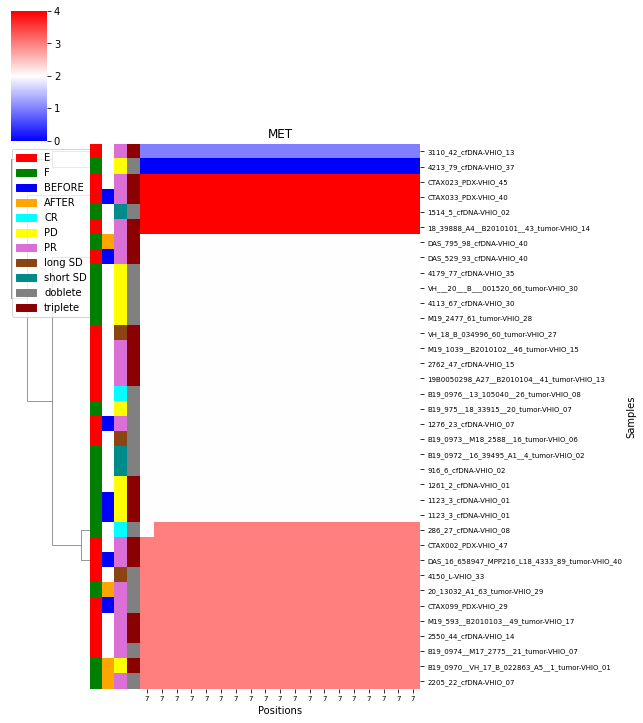

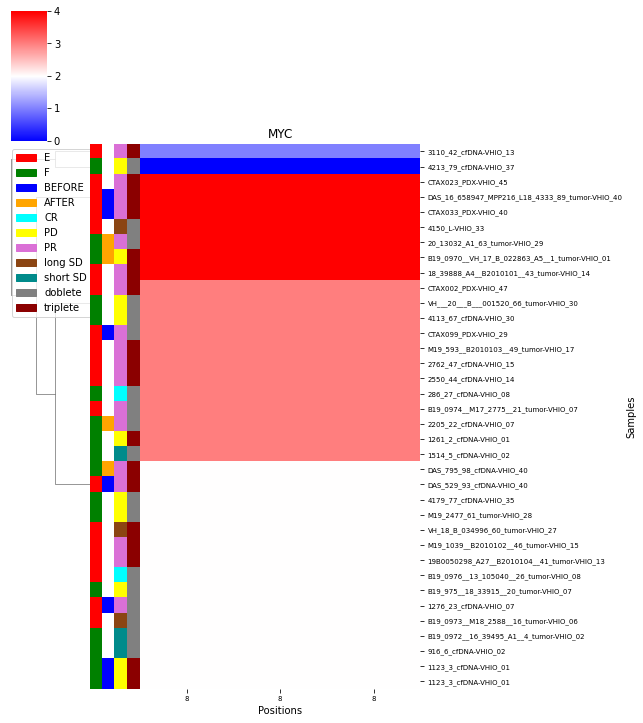

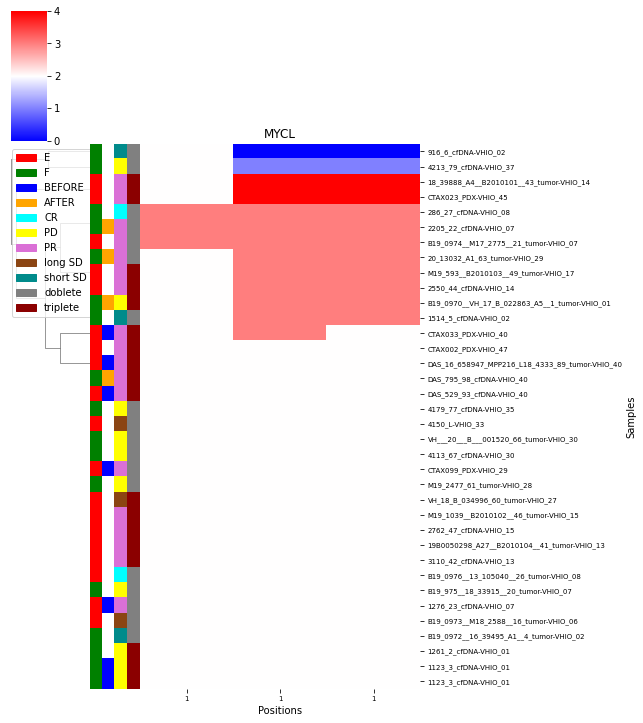

In [7]:
for name, group in cnvs.iloc[:,1:].groupby('GENE', axis=0):
    if name in ['MYC', 'MYCL', 'MET', 'EGFR', 'BRAF']:
        data = group.iloc[:,1:].transpose()
        data[data == 'Na'] = np.nan
        data = data.astype('float')
        data = data.dropna(how='all', axis=0)
        data = data.dropna(how='all', axis=1)
        min_value = np.nanmin(data.to_numpy())
        if min_value == -1:
            total = 5
        elif min_value == 0:
            total = 4
        else:
            total = 3
        data[data > total] = total
        data = data.fillna(2)
        plot_heatmap(data, meta_filtered, name, name + "_scaled.pdf", False, True)

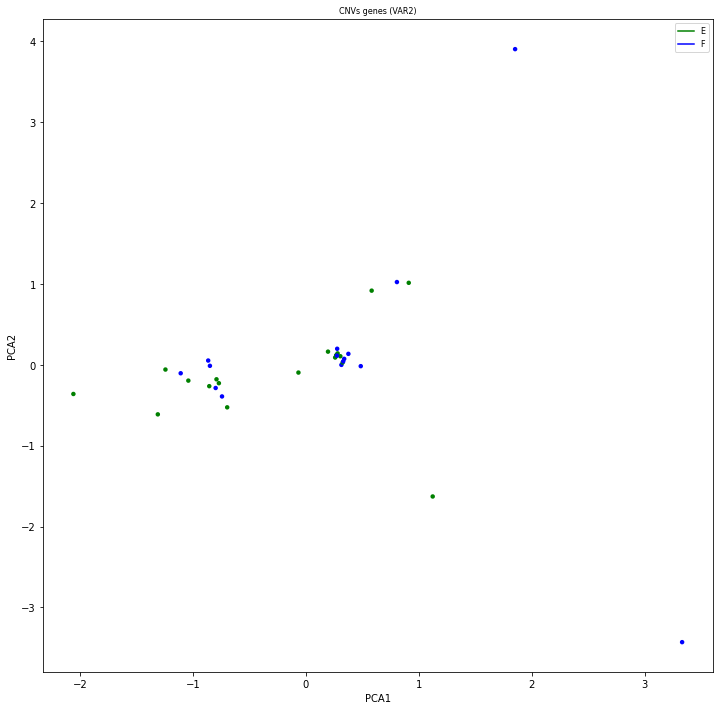

In [14]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, StandardScaler

meta = meta_filtered[meta_filtered['VAR2'].notnull()]
data = cnvs_genes.loc[:, meta.index.tolist()].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data = data.fillna(2)
#scaler = StandardScaler()
#data = scaler.fit_transform(data)
#sel = VarianceThreshold(threshold=0.1)
#data = sel.fit_transform(data)
data[data < 0] = 0
data = np.log1p(data)

reduced_data = PCA(whiten=True, n_components=2).fit_transform(data)

labels = [1 if x == 'E' else 2 for x in meta['VAR2']]
plot_pca(x=reduced_data[:, 0], 
         y=reduced_data[:, 1], 
         colors=labels,
         labels=['E', 'F'],
         title='CNVs genes (VAR2)',
         filename='pca_var1.pdf')

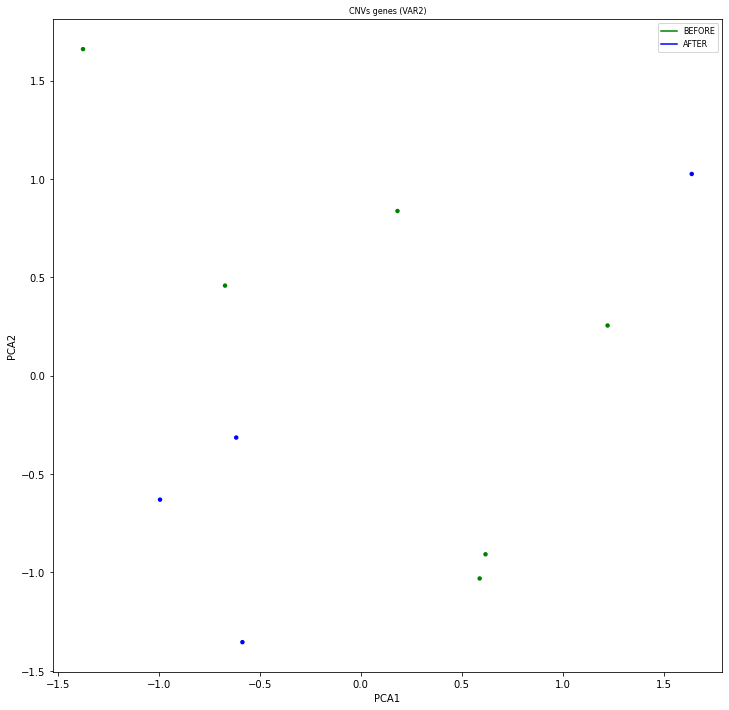

In [15]:
meta = meta_filtered[meta_filtered['VAR1'].notnull()]
data = cnvs_genes.loc[:, meta.index.tolist()].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data = data.fillna(2)
data[data < 0] = 0
data = np.log1p(data)

reduced_data = PCA(whiten=True, n_components=2).fit_transform(data)

labels = [1 if x == 'BEFORE' else 2 for x in meta['VAR1']]
plot_pca(x=reduced_data[:, 0], 
         y=reduced_data[:, 1], 
         colors=labels,
         labels=['BEFORE', 'AFTER'],
         title='CNVs genes (VAR2)',
         filename='pca_var2.pdf')

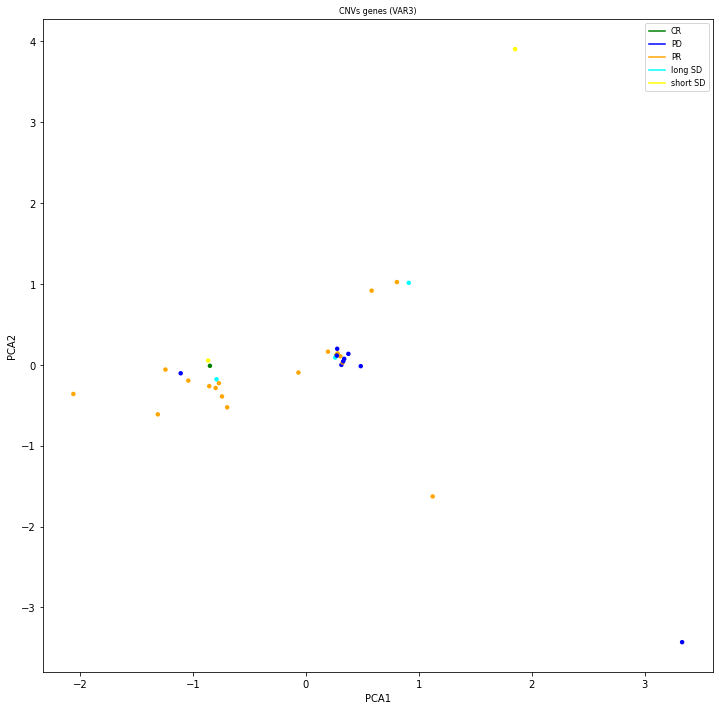

In [16]:
meta = meta_filtered[meta_filtered['VAR3'].notnull()]
data = cnvs_genes.loc[:, meta.index.tolist()].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data = data.fillna(2)
data[data < 0] = 0
data = np.log1p(data)

reduced_data = PCA(whiten=True, n_components=2).fit_transform(data)

var3 = meta['VAR3'].copy()
var3.loc[var3 == 'CR'] = 1
var3.loc[var3 == 'PD'] = 2
var3.loc[var3 == 'PR'] = 3
var3.loc[var3 == 'long SD'] = 4
var3.loc[var3 == 'short SD'] = 5
labels = ['CR', 'PD', 'PR', 'long SD', 'short SD']
plot_pca(x=reduced_data[:, 0], 
         y=reduced_data[:, 1], 
         colors=var3.to_list(),
         labels=labels,
         title='CNVs genes (VAR3)',
         filename='pca_var3.pdf')

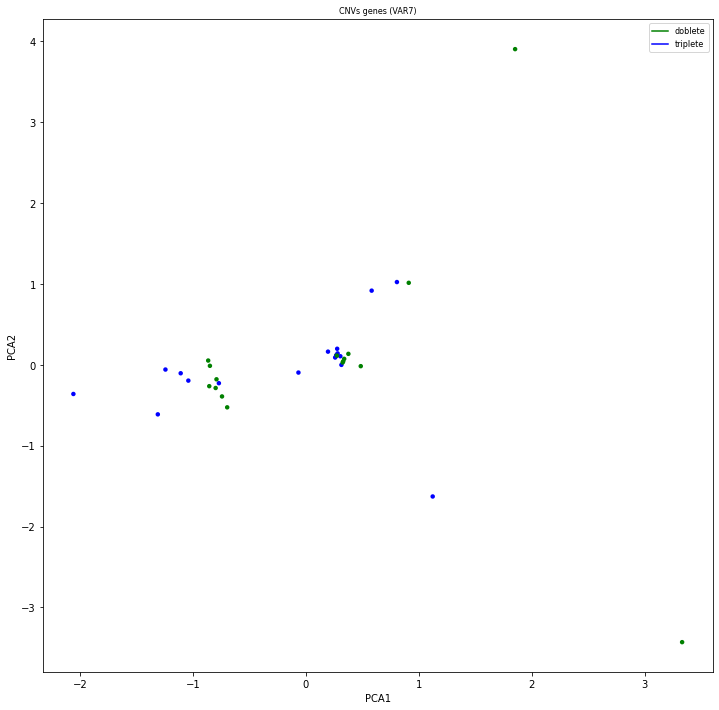

In [18]:
meta = meta_filtered[meta_filtered['VAR7'].notnull()]
data = cnvs_genes.loc[:, meta.index.tolist()].transpose()
data[data == 'Na'] = np.nan
data = data.astype('float')
data = data.fillna(2)
data[data < 0] = 0
data = np.log1p(data)

reduced_data = PCA(whiten=True, n_components=2).fit_transform(data)

var7 = meta['VAR7'].copy()
var7.loc[var7 == 'doblete'] = 1
var7.loc[var7 == 'triplete'] = 2
labels = ['doblete', 'triplete']
plot_pca(x=reduced_data[:, 0], 
         y=reduced_data[:, 1], 
         colors=var7.to_list(),
         labels=labels,
         title='CNVs genes (VAR7)',
         filename='pca_var7.pdf')